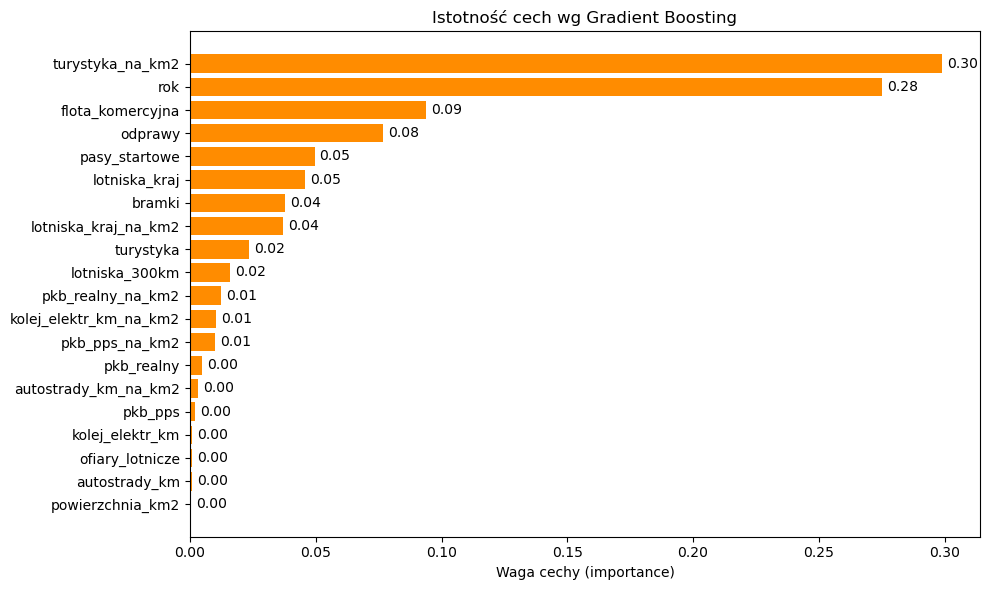

In [13]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt

# Wczytanie danych
path = "oczyszczone_dane_lotniska.xlsx"
df = pd.read_excel(path)

# Zamiana przecinków na kropki i konwersja do wartości liczbowych dla wybranych kolumn
cols_to_fix = ['autostrady_km', 'kolej_elektr_km', 'turystyka', 'lotniska_kraj', 'pkb_pps', 'pkb_realny']
for col in cols_to_fix:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(",", ".").str.replace(" ", "").str.replace("–", "", regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Uzupełnianie brakujących danych średnią dla każdego lotniska
df_grouped = df.copy()
for col in cols_to_fix + ['powierzchnia_km2', 'pax']:
    df_grouped[col] = df[col].fillna(df.groupby('lotnisko')[col].transform('mean'))

# Uzupełnienie pozostałych braków średnią globalną
for col in df_grouped.select_dtypes(include='number').columns:
    df_grouped[col] = df_grouped[col].fillna(df_grouped[col].mean())

# Dodanie nowych zmiennych przeliczonych na km2
pow = df_grouped['powierzchnia_km2']
df_grouped['autostrady_km_na_km2'] = df_grouped['autostrady_km'] / pow
df_grouped['kolej_elektr_km_na_km2'] = df_grouped['kolej_elektr_km'] / pow
df_grouped['turystyka_na_km2'] = df_grouped['turystyka'] / pow
df_grouped['lotniska_kraj_na_km2'] = df_grouped['lotniska_kraj'] / pow
df_grouped['pkb_pps_na_km2'] = df_grouped['pkb_pps'] / pow
df_grouped['pkb_realny_na_km2'] = df_grouped['pkb_realny'] / pow

# Przygotowanie danych
X = df_grouped.select_dtypes(include='number').drop(columns=['pax'])
y = df_grouped['pax']

# Trenowanie modelu Gradient Boosting
model = GradientBoostingRegressor(random_state=42)
model.fit(X, y)

# Istotność cech
importance = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance}).sort_values(by='Importance', ascending=True)

# Wykres
plt.figure(figsize=(10, 6))
bars = plt.barh(importance_df['Feature'], importance_df['Importance'], color='darkorange')
plt.xlabel("Waga cechy (importance)")
plt.title("Istotność cech wg Gradient Boosting")
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.002, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')
plt.tight_layout()
plt.show()

